# ABC-SMC

PINTS can be used to perform inference for stochastic forward models. Here, we perform inference on the [stochastic degradation model](../toy/model-stochastic-degradation.ipynb) using Approximate Bayesian Computation (ABC). This model has only a single unknown parameter -- the rate at which chemicals degrade. We use the "ABC SMC" method to estimate this unknown and provide a measure of uncertainty in it.

First, we load the stochastic degradation model and perform 10 simulations from it. The variation inbetween runs is due to the inherent stochasticity of this type of model.

In [1]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

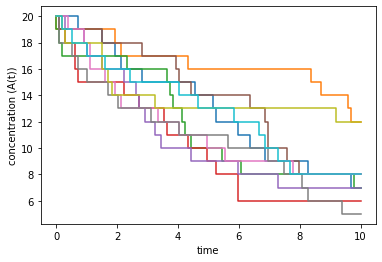

In [2]:
np.random.seed(5)

# Load a forward model
model = toy.stochastic.DegradationModel()

# Create some toy data
real_parameters = model.suggested_parameters()
times = np.linspace(0, 10, 100)

for i in range(10):
    values = model.simulate(real_parameters, times)

    # Create an object with links to the model and time series
    problem = pints.SingleOutputProblem(model, times, values)

    # Create a uniform prior parameter
    log_prior = pints.UniformLogPrior([0.0], [0.3])

    # Set the error measure to be used to compare simulated to observed data
    error_measure = pints.RootMeanSquaredError(problem)

    plt.step(times, values)


plt.xlabel('time')
plt.ylabel('concentration (A(t))')
plt.show()

## Fit using ABC SMC

The ABC SMC method can be used to perform parameter inference for stochastic models, where the likelihood is intractable. In ABC methods, typically, a distance metric comparing the observed data and the simulated is used. Here, we use the root mean square error (RMSE), and we accept a parameter value if the $RMSE<3$ for the first intermediate distribution, $RMSE<1.5$ for the second one and $RMSE<1$ for the last. The size of the intermediate distributions will be 200.

In [3]:
np.random.seed(1)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([3,1.5,1]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1400)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=3.0
Iter. Eval. Acceptance rate Time m:s
1     2      0.5              0:00.0
2     9      0.222222222      0:00.0
3     13     0.230769231      0:00.0
20    68     0.294117647      0:00.1
40    126    0.317460317      0:00.1
60    174    0.344827586      0:00.1
80    225    0.355555556      0:00.1
100   301    0.332225914      0:00.2
120   349    0.343839542      0:00.2
140   415    0.337349398      0:00.2
160   473    0.338266384778   0:00.3
180   546    0.32967033       0:00.3
Starting t=1, with threshold=1.5
200   608    0.328947368      0:00.3
220   755    0.291390728      0:00.4
240   861    0.278745645      0:00.5
260   1003   0.259222333001   0:00.6
280   1151   0.243266725      0:00.7
300   1298   0.231124807396   0:00.8
320   1411   0.226789511      0:00.9
340   1604   0.211970074813   0:01.0
360   1744   0.206422018      0:01.1
380   1855   0.204851752      0:01.2
Starting t=2, with threshold=1

We now plot the ABC posterior samples versus the actual value that was used to generate the data. This shows that, in this case, the parameter could be identified given the data. We only plot the last generation (by discarding the 400 samples generated by the other generations) as they are significantly more accurate.

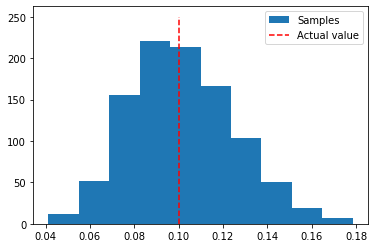

In [12]:
plt.hist([x[0] for x in samples[400:]], label='Samples')

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=250, label='Actual value', color='red')
plt.legend()
plt.show()

# Using the ask and tell interface

We can use the ask-and-tell interface to visualise the algorithm's behaviour. In this example we run ABC-SMC with 3 successive generations and plot each generation separately. As expected, the samples are getting narrower and more accurate in later generations.

In [13]:
abcsmc = pints.ABCSMC(log_prior, nr_samples=200, error_schedule=np.array([3,1.5,1]))

evaluator = pints.SequentialEvaluator(error_measure)

print("Starting sampler")
f = []
s = []
l = []
cnt = 0
np.random.seed(1)
running = True
while cnt < 1400:
    accepted_vals = None
    while accepted_vals is None:
        xs = abcsmc.ask(1)
        fxs = evaluator.evaluate(xs)
        accepted_vals = abcsmc.tell(fxs)
    if cnt < 200:
        for val in accepted_vals:
            f.append(val)
    elif cnt < 400:
        for val in accepted_vals:
            s.append(val)
    else:
        for val in accepted_vals:
            l.append(val)
    cnt += len(accepted_vals)

print("Sampler finished")

Starting sampler
Starting t=0, with threshold=3.0
Starting t=1, with threshold=1.5
Starting t=2, with threshold=1.0
Sampler finished


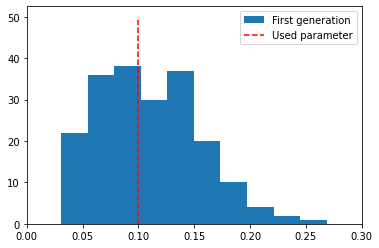

In [20]:
plt.hist([x[0] for x in f], bins=10, label='First generation')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50, label='Used parameter', color='red')
plt.legend()
plt.show()

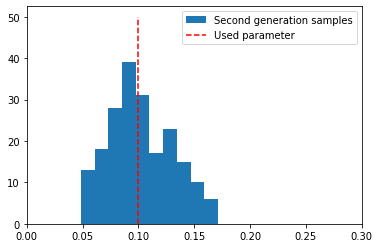

In [21]:
plt.hist([x[0] for x in s], bins=10, label='Second generation samples')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=50, label='Used parameter', color='red')
plt.legend()
plt.show()

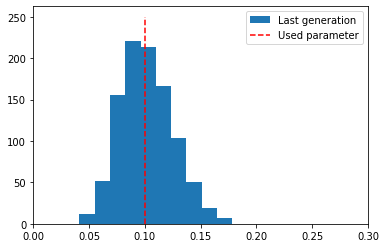

In [24]:
plt.hist([x[0] for x in l], bins=10, label='Last generation')
plt.xlim(0, 0.3)

plt.vlines(x=model.suggested_parameters(), linestyles='dashed', ymin=0, ymax=250, label='Used parameter', color='red')
plt.legend()
plt.show()